## Detecting Twitter Bots

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [25]:
filepath = '/home/damion/Desktop/kaggle_data/'
file= 'training_data_5.csv'

training_data = pd.read_csv(file)
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]


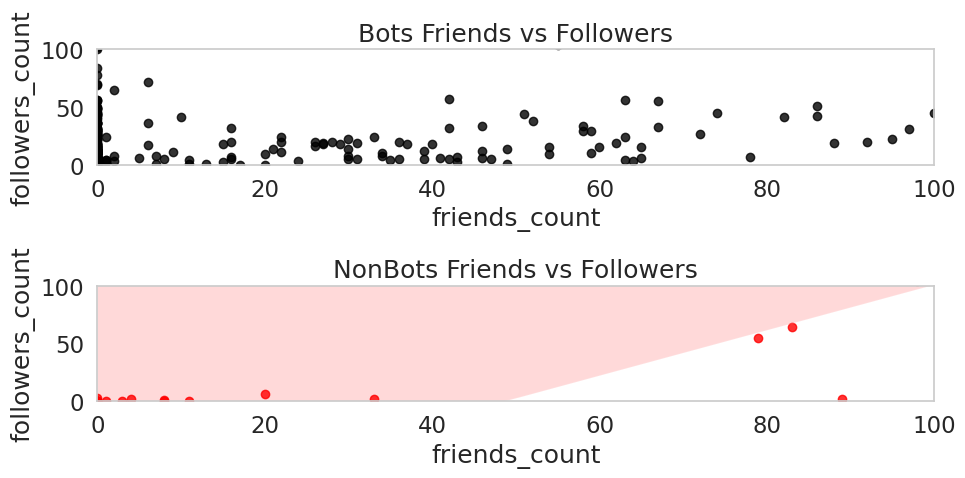

In [26]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(x=bots.friends_count, y=bots.followers_count, color='black', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(x=nonbots.friends_count, y=nonbots.followers_count, color='red', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [27]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(54, 13)

In [28]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

In [29]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)

bots['verified_binary'] = (bots.verified==False)
bots.shape

(554, 15)

In [30]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)

nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(103, 15)

In [31]:
df = pd.concat([bots, nonbots])

df.shape

(657, 15)

In [32]:
filepath = '/home/damion/Desktop/kaggle_data/'
file= open('training_data_5.csv', mode='r', encoding='utf-8', errors='ignore')

training_data = pd.read_csv(file)

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)

training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

#### Performing Feature Extraction

In [33]:

features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1] #iloc gives us row,all column elements except the last one
y = training_data[features].iloc[:,-1] # iloc gives us row,only the last column element

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101) #splits arrays or matrices into random train and test subsets

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Training Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Training Accuracy: 0.85772
Test Accuracy: 0.84848


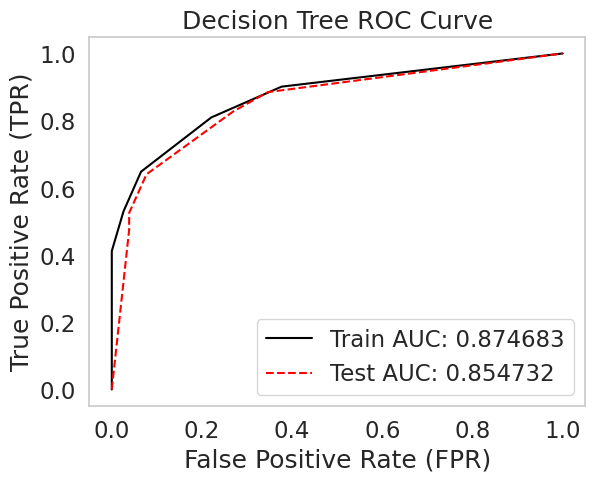

In [22]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Result: Decision Tree gives very good performance and generalizes well. But it may be overfitting as AUC is 0.937, so we will try other models.

#### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.84314
Test Accuracy: 0.84343


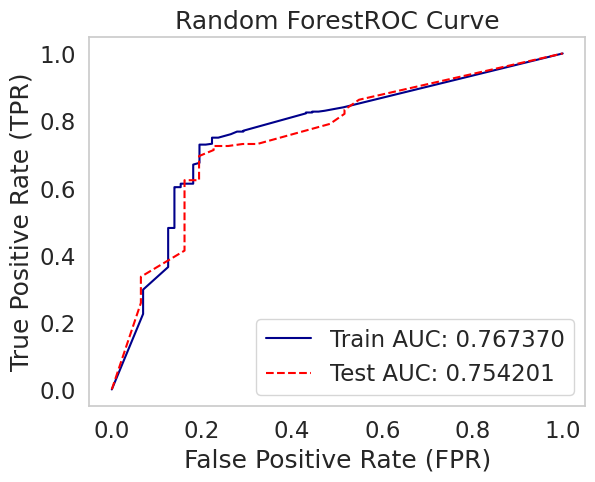

In [30]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

### Thank you.